# Heuristic Code

In [1]:
import numpy as np
from lpm_methods import regression as find_subset

# Computes the linear regression loss when regressing the vector b against A.
def lin_reg(A, b):
    temp = np.transpose(A) @ b
    return np.dot(b, b) - np.dot(temp, np.linalg.inv(np.transpose(A) @ A) @ temp)

## Orthogonal Matching Pursuit

In [2]:
# A simple greedy algorithm for subset selection.
def omp(A, b, k):
    n = A.shape[1]
    A = A.copy()
    b = b.copy()
    T = []
    bests = []
    for t in range(k):
        best = -1
        best_obj = None
        
        for i in range(n):
            if np.linalg.norm(A[:,i]) < 1e-5:
                continue
            obj = np.dot(b, A[:,i]) / np.linalg.norm(A[:,i])
            if best_obj is None or obj > best_obj:
                best = i
                best_obj = obj 
                
        T.append(best)
        best_vec = A[:, best].copy() / np.linalg.norm(A[:,best])
        for i in range(n):
            A[:,i] -= np.dot(best_vec, A[:,i]) * best_vec
        b -= np.dot(best_vec, b) * best_vec
        bests.append(np.linalg.norm(b)**2)
    return T, bests

# Test Code

In [3]:
import time
def hyp_test(A, b, k_min, k_max):
    hyp_scores = dict()
    hyp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T = find_subset(A,b,i)
        end_time = time.time()
        hyp_timings[i] = end_time - start_time
        hyp_scores[i] = lin_reg(A[:,T], b)        
    return hyp_scores, hyp_timings

def omp_test(A, b, k_min, k_max):
    omp_scores = dict()
    omp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = omp(A,b,i)
        end_time = time.time()
        omp_timings[i] = end_time - start_time
        omp_scores[i] = lin_reg(A[:,T], b)
    return omp_scores, omp_timings

from sklearn import linear_model
def lasso_test(A, b, threshold, alphas, k_min, k_max, use_threshold=False):
    # Set the starting scores to be something larger than what we would expect
    lasso_scores = {k : None for k in range(k_min, k_max)}
    lasso_timings = dict()
    for alpha in alphas:
        # Use exponentially decreasing values of alpha to get different sizes of support
        clf = linear_model.Lasso(alpha=alpha, max_iter=10000000)
        start_time = time.time()
        clf.fit(A,b)
        end_time = time.time()
        if use_threshold:
            T = [i for i,x in enumerate(clf.coef_) if abs(x) >= threshold]
            k = len(T)
            if k < k_min or k >= k_max:
                continue
            score = lin_reg(A[:,T], b)
            if lasso_scores[k] is None  or lasso_scores[k] > score:
                lasso_scores[k] = score
                lasso_timings[k] = end_time - start_time
        else:
            coeffs = sorted(list(enumerate(clf.coef_)), key=lambda x: -abs(x[1]))
            ranking = [x[0] for x in coeffs]
            for k in range(k_min, k_max):
                T = ranking[:k]
                score = lin_reg(A[:,T], b)
                if lasso_scores[k] is None or score < lasso_scores[k]:
                    lasso_timings[k] = end_time - start_time
                    lasso_scores[k] = score
    return lasso_scores, lasso_timings

import matplotlib.pyplot as plt

def plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max):
    # plot lasso
    if lasso_scores is not None:
        lasso_xs = [k for k in range(k_min, k_max) if lasso_scores[k] is not None]
        lasso_ys = [lasso_scores[k] for k in lasso_xs]
        plt.plot(lasso_xs, lasso_ys, label="Lasso")

    # plot hyp
    if hyp_scores is not None:
        hyp_xs = list(range(k_min, k_max))
        hyp_ys = [hyp_scores[k] for k in hyp_xs]
        plt.plot(hyp_xs, hyp_ys, label="Greedy Cond")

    # plot omp|
    if omp_scores is not None:
        omp_xs = list(range(k_min, k_max))
        omp_ys = [omp_scores[k] for k in omp_xs]
        plt.plot(omp_xs, omp_ys, label="omp")
    
    plt.xticks(list(range(k_min,k_max)))
    plt.xlabel("k")
    plt.ylabel("L2 Error")

    plt.legend()
    plt.show()

# Superconductivity Example

In [5]:
import pandas as pd
df = pd.read_csv("data/superconduct.csv", delimiter=",")
df = (df - df.mean())/df.std()
A = df.to_numpy()

b = A[:,-1]
A = A[:,:-1]
k_min = 2
k_max = 20
A_copy = A.copy()
hyp_scores, hyp_timings = hyp_test(A_copy, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(50)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

LinAlgError: Singular matrix

# Violent Crime

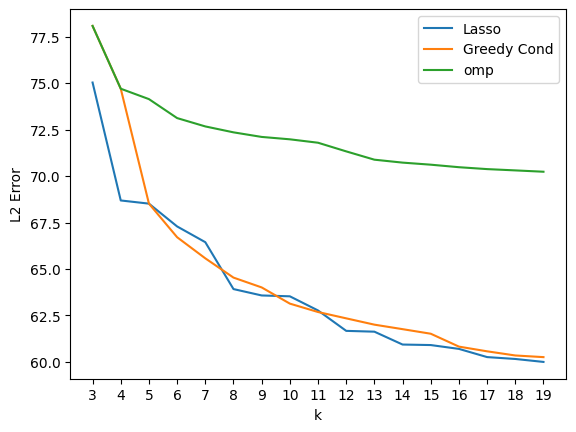

[[3, 0.007975101470947266, 0.008685588836669922, 0.039910316467285156], [4, 0.00953817367553711, 0.011391401290893555, 0.039910316467285156], [5, 0.011123418807983398, 0.01390385627746582, 0.039910316467285156], [6, 0.012566089630126953, 0.016712188720703125, 0.0169370174407959], [7, 0.014093399047851562, 0.0193023681640625, 0.021433115005493164], [8, 0.015635251998901367, 0.022086143493652344, 0.039910316467285156], [9, 0.017222166061401367, 0.02479386329650879, 0.039910316467285156], [10, 0.018649816513061523, 0.027696609497070312, 0.039910316467285156], [11, 0.02012777328491211, 0.030896663665771484, 0.039910316467285156], [12, 0.021524667739868164, 0.03339195251464844, 0.039910316467285156], [13, 0.02294015884399414, 0.03562641143798828, 0.039910316467285156], [14, 0.02418804168701172, 0.03820443153381348, 0.039910316467285156], [15, 0.025518178939819336, 0.040354251861572266, 0.039910316467285156], [16, 0.027016878128051758, 0.043237924575805664, 0.021112442016601562], [17, 0.0289

In [5]:
import pandas as pd
df = pd.read_csv("../sparse_qcqp_code/data/CommViolPredUnnormalizedData.txt", delimiter=",")
# Only take interesting columns
df = df.iloc[:,5:-17].replace("?", None).dropna(axis=1)
df = (df - df.mean())/df.std()
A = df.to_numpy()
b = A[:,-1]
A = A[:,:-1]

k_min = 3
k_max = 20
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(10)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Sklearn Diabetes Data

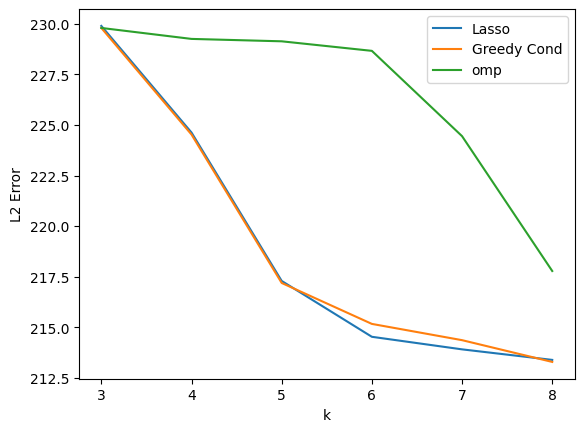

[[3, 7.104873657226562e-05, 0.0004069805145263672, 0.000667572021484375], [4, 5.7220458984375e-05, 0.0005102157592773438, 0.000667572021484375], [5, 6.222724914550781e-05, 0.0006213188171386719, 0.0003304481506347656], [6, 6.842613220214844e-05, 0.0007205009460449219, 0.00077056884765625], [7, 7.62939453125e-05, 0.0008254051208496094, 0.00077056884765625], [8, 8.58306884765625e-05, 0.0009512901306152344, 0.00077056884765625]]


In [6]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
A = diabetes["data"]
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b = diabetes["target"]
b -= np.mean(b)
b /= np.std(b)

k_min = 3
k_max = 9
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, {x:lasso_scores[x]+0.1 for x in lasso_scores}, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Wine Dataset

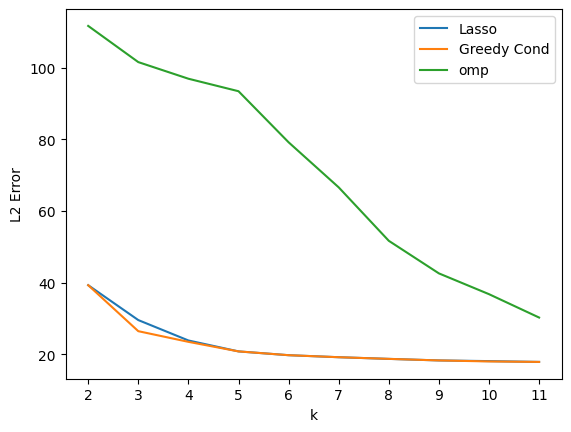

[[2, 6.651878356933594e-05, 0.0004227161407470703, 0.00046753883361816406], [3, 8.702278137207031e-05, 0.0004658699035644531, 0.0002689361572265625], [4, 7.486343383789062e-05, 0.0005567073822021484, 0.00046753883361816406], [5, 8.7738037109375e-05, 0.00067901611328125, 0.00046753883361816406], [6, 9.965896606445312e-05, 0.0008034706115722656, 0.00046753883361816406], [7, 0.00011157989501953125, 0.0009064674377441406, 0.00046753883361816406], [8, 0.00012421607971191406, 0.0011675357818603516, 0.0003104209899902344], [9, 0.00013899803161621094, 0.0011296272277832031, 0.0003104209899902344], [10, 0.00014400482177734375, 0.0012271404266357422, 0.00046753883361816406], [11, 0.0001544952392578125, 0.0013267993927001953, 0.0002841949462890625]]


In [7]:
from sklearn.datasets import load_wine
wine = load_wine()
A = wine["data"].astype(float)
b = wine["target"].astype(float)
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b -= np.mean(b)
b /= np.std(b)

k_min = 2
k_max = 12
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.05 ** (t-400) for t in range(500)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Regression with random matrices

In [8]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.02)
import random
def test(n,m,k):
    T = random.sample(list(range(n)), k)
    T.sort()
    print("T: ", T)
    A = np.random.normal(loc = 0, scale = 1, size = (m,n))
    b = sum(A[:,i] for i in T)
    S1 = find_subset(A, b, k)
    print("characteristic: ", S1)
    S1.sort()
    s1 = all(s == t for t, s in zip(T, S1))
    lasso = clf.fit(A, b).coef_
    S2 = [a[1] for a in sorted([(-abs(x),i) for i,x in enumerate(lasso)])[:k]]
    S2.sort()
    s2 = all(s == t for t, s in zip(T, S2))
    S3, scores3 = omp(A,b,k)
    print("omp: ", S3)
    S3.sort()
    s3 = all(s == t for t, s in zip(T, S3))
    norm_b = np.linalg.norm(b)
    return (s1,s2,s3)

In [9]:
n = 100
m = 30
iters = 10
count_dict = []
for k in range(6,25):
    counts = [0,0,0]
    for i in range(iters):
        for i, result in enumerate(test(n,m,k)):
            if result:
                counts[i] += 1
    print(counts)
    count_dict.append(counts)
print(count_dict)

T:  [20, 54, 56, 70, 83, 97]
characteristic:  [54, 56, 20, 83, 97, 70]
omp:  [54, 56, 20, 83, 97, 70]
T:  [5, 27, 34, 53, 60, 67]
characteristic:  [67, 40, 34, 60, 14, 8]
omp:  [67, 40, 34, 60, 14, 41]
T:  [27, 30, 47, 51, 60, 61]
characteristic:  [30, 49, 13, 98, 72, 5]
omp:  [30, 61, 27, 51, 60, 47]
T:  [38, 53, 56, 61, 63, 70]
characteristic:  [38, 61, 53, 70, 63, 56]
omp:  [38, 61, 53, 70, 63, 56]
T:  [12, 21, 35, 62, 82, 95]
characteristic:  [82, 95, 94, 1, 54, 14]
omp:  [82, 95, 12, 74, 62, 35]
T:  [9, 20, 48, 55, 60, 95]
characteristic:  [60, 9, 48, 20, 95, 55]
omp:  [60, 9, 48, 20, 95, 55]
T:  [22, 40, 54, 66, 67, 77]
characteristic:  [67, 40, 54, 77, 22, 66]
omp:  [67, 40, 54, 77, 22, 66]
T:  [3, 35, 59, 65, 82, 90]
characteristic:  [59, 35, 82, 65, 3, 90]
omp:  [59, 35, 82, 65, 3, 90]
T:  [31, 32, 38, 50, 75, 82]
characteristic:  [50, 16, 69, 49, 32, 82]
omp:  [50, 16, 75, 32, 82, 38]
T:  [2, 20, 28, 71, 85, 93]
characteristic:  [71, 40, 70, 2, 37, 65]
omp:  [71, 40, 70, 74, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.332e-02, tolerance: 2.240e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [78, 52, 43, 79, 15, 41, 4, 93, 5]
T:  [7, 12, 26, 37, 38, 39, 47, 57, 75]
characteristic:  [46, 88, 21, 51, 84, 75, 26, 99, 31]
omp:  [39, 57, 84, 15, 34, 26, 47, 7, 12]
T:  [5, 17, 20, 31, 40, 45, 55, 56, 91]
characteristic:  [40, 5, 74, 71, 73, 56, 47, 84, 17]
omp:  [40, 5, 59, 55, 20, 17, 56, 45, 31]
T:  [34, 44, 49, 64, 66, 78, 91, 92, 94]
characteristic:  [94, 49, 91, 63, 34, 11, 51, 68, 96]
omp:  [94, 49, 91, 19, 34, 66, 41, 92, 78]
T:  [2, 10, 11, 12, 15, 16, 34, 74, 92]
characteristic:  [92, 12, 93, 95, 15, 47, 2, 16, 85]
omp:  [92, 12, 93, 95, 15, 85, 2, 16, 11]
[0, 3, 0]
T:  [3, 4, 11, 12, 15, 21, 59, 64, 69, 82]
characteristic:  [15, 4, 84, 95, 90, 86, 11, 3, 70, 79]
omp:  [15, 23, 4, 59, 64, 11, 82, 12, 36, 21]
T:  [6, 13, 17, 24, 31, 55, 69, 77, 83, 97]
characteristic:  [56, 28, 24, 4, 9, 1, 75, 36, 96, 45]
omp:  [55, 53, 25, 69, 59, 31, 24, 35, 17, 6]
T:  [10, 14, 29, 53, 60, 63, 67, 68, 77, 84]
characteristic:  [60, 68, 10, 85, 3, 96, 82, 61, 55, 72]
omp:  [60, 68

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.002e-02, tolerance: 3.925e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.426e-02, tolerance: 3.773e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [74, 49, 45, 51, 75, 60, 35, 55, 93, 86, 8]
T:  [2, 10, 17, 24, 33, 42, 46, 64, 66, 75, 86]
characteristic:  [33, 24, 37, 58, 85, 10, 86, 60, 35, 81, 31]
omp:  [33, 24, 37, 86, 56, 42, 17, 67, 60, 97, 94]
T:  [0, 7, 13, 19, 33, 41, 54, 64, 78, 91, 93]
characteristic:  [33, 41, 64, 54, 78, 67, 5, 37, 19, 49, 93]
omp:  [33, 41, 54, 64, 78, 0, 91, 13, 19, 93, 7]
T:  [16, 19, 38, 40, 52, 56, 72, 74, 83, 84, 98]
characteristic:  [38, 19, 40, 84, 30, 90, 12, 11, 39, 65, 97]
omp:  [38, 19, 40, 84, 53, 90, 83, 52, 16, 43, 7]
T:  [10, 17, 18, 25, 28, 29, 37, 83, 90, 96, 97]
characteristic:  [18, 25, 94, 38, 41, 28, 74, 88, 16, 40, 44]
omp:  [18, 25, 38, 29, 28, 96, 36, 89, 10, 50, 3]
T:  [1, 3, 41, 45, 53, 54, 60, 68, 70, 80, 83]
characteristic:  [54, 41, 2, 47, 97, 10, 60, 73, 64, 48, 49]
omp:  [54, 41, 30, 75, 47, 1, 16, 93, 97, 96, 40]
T:  [3, 8, 9, 18, 33, 49, 50, 77, 89, 96, 98]
characteristic:  [33, 18, 77, 68, 26, 19, 66, 58, 16, 39, 0]
omp:  [33, 18, 77, 19, 66, 98, 8, 73, 60, 2, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e-01, tolerance: 4.042e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.094e-02, tolerance: 2.983e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [2, 64, 88, 95, 41, 99, 18, 7, 77, 69, 72, 78]
T:  [1, 11, 24, 35, 54, 57, 69, 75, 83, 94, 97, 99]
characteristic:  [1, 99, 45, 94, 68, 75, 97, 25, 15, 51, 90, 5]
omp:  [1, 99, 97, 75, 94, 54, 24, 62, 51, 13, 12, 57]
T:  [9, 11, 20, 24, 26, 38, 48, 54, 63, 88, 89, 90]
characteristic:  [20, 38, 7, 61, 18, 52, 0, 83, 71, 89, 21, 9]
omp:  [20, 38, 7, 55, 89, 54, 34, 11, 26, 88, 30, 98]
T:  [3, 7, 21, 32, 38, 41, 56, 61, 72, 77, 80, 83]
characteristic:  [37, 61, 91, 99, 53, 87, 17, 6, 66, 79, 33, 30]
omp:  [3, 72, 83, 80, 77, 7, 51, 89, 82, 92, 21, 70]
T:  [4, 7, 19, 25, 47, 52, 53, 70, 74, 79, 87, 96]
characteristic:  [15, 14, 6, 71, 12, 79, 65, 61, 82, 72, 59, 53]
omp:  [15, 52, 9, 25, 53, 74, 70, 19, 47, 59, 0, 94]
T:  [3, 7, 16, 23, 25, 26, 39, 69, 74, 78, 88, 92]
characteristic:  [59, 69, 3, 7, 93, 21, 16, 40, 44, 34, 22, 33]
omp:  [59, 69, 3, 7, 78, 74, 23, 92, 49, 41, 16, 21]
T:  [0, 5, 9, 10, 52, 53, 64, 79, 88, 89, 93, 99]
characteristic:  [64, 5, 89, 79, 44, 16, 40, 60, 93,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.256e-02, tolerance: 5.300e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [68, 99, 84, 36, 1, 51, 13, 17, 82, 73, 46, 67, 34]
T:  [2, 25, 30, 34, 36, 39, 50, 63, 66, 67, 69, 70, 89]
characteristic:  [91, 30, 97, 84, 66, 41, 98, 69, 77, 87, 82, 36, 25]
omp:  [91, 30, 46, 4, 36, 50, 93, 2, 63, 43, 47, 83, 54]
T:  [4, 9, 10, 20, 26, 34, 38, 39, 63, 73, 80, 87, 98]
characteristic:  [39, 4, 77, 98, 63, 82, 25, 73, 38, 64, 53, 90, 32]
omp:  [39, 4, 56, 26, 41, 89, 38, 46, 60, 98, 73, 10, 63]
T:  [5, 9, 11, 22, 39, 41, 50, 55, 57, 59, 68, 83, 99]
characteristic:  [41, 56, 9, 15, 26, 83, 36, 95, 88, 57, 71, 32, 47]
omp:  [41, 56, 9, 15, 6, 7, 59, 55, 57, 42, 97, 69, 4]
T:  [6, 10, 12, 13, 19, 22, 26, 36, 44, 55, 66, 72, 74]
characteristic:  [36, 30, 95, 1, 32, 53, 29, 63, 70, 34, 17, 46, 3]
omp:  [36, 30, 95, 55, 13, 44, 34, 12, 26, 53, 70, 91, 49]
T:  [8, 11, 13, 15, 25, 44, 73, 77, 79, 90, 91, 93, 98]
characteristic:  [13, 20, 11, 81, 21, 91, 32, 24, 94, 63, 55, 26, 40]
omp:  [13, 11, 37, 98, 15, 16, 93, 52, 8, 91, 79, 75, 3]
[0, 0, 1]
T:  [3, 21, 26, 30, 37

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.113e-02, tolerance: 4.393e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e-01, tolerance: 4.901e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [5, 20, 14, 34, 72, 42, 99, 10, 70, 7, 38, 97, 24, 77]
omp:  [5, 20, 14, 72, 34, 66, 63, 10, 7, 35, 12, 81, 24, 11]
T:  [0, 2, 3, 6, 10, 25, 30, 33, 55, 57, 61, 72, 77, 90]
characteristic:  [2, 0, 57, 24, 30, 23, 98, 50, 83, 77, 68, 80, 32, 26]
omp:  [2, 0, 30, 50, 61, 77, 48, 85, 21, 71, 11, 33, 92, 81]
T:  [5, 24, 29, 42, 45, 49, 51, 55, 57, 58, 63, 76, 80, 83]
characteristic:  [45, 80, 49, 30, 51, 99, 76, 5, 22, 38, 33, 96, 12, 6]
omp:  [45, 2, 47, 7, 71, 83, 34, 62, 53, 85, 58, 98, 31, 76]
T:  [1, 2, 4, 19, 22, 24, 52, 60, 62, 63, 64, 71, 74, 91]
characteristic:  [22, 52, 64, 59, 0, 43, 91, 85, 35, 69, 97, 6, 68, 38]
omp:  [19, 62, 71, 87, 64, 36, 52, 22, 74, 0, 4, 13, 91, 63]
T:  [9, 15, 16, 20, 26, 27, 50, 54, 57, 58, 59, 70, 78, 98]
characteristic:  [82, 56, 98, 70, 15, 27, 46, 68, 49, 83, 57, 94, 81, 91]
omp:  [15, 54, 41, 70, 89, 78, 3, 21, 75, 94, 24, 96, 72, 32]
T:  [8, 18, 20, 25, 28, 33, 35, 40, 49, 54, 62, 78, 79, 93]
characteristic:  [98, 1, 79, 29, 33, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e-02, tolerance: 4.887e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e-01, tolerance: 5.690e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [55, 66, 38, 23, 28, 26, 50, 65, 98, 7, 77, 33, 37, 25, 30]
T:  [1, 10, 13, 15, 22, 42, 45, 51, 69, 73, 83, 86, 91, 92, 99]
characteristic:  [10, 43, 97, 30, 75, 66, 73, 70, 24, 33, 54, 7, 0, 45, 44]
omp:  [10, 45, 51, 33, 21, 92, 73, 22, 49, 79, 60, 13, 78, 69, 91]
T:  [1, 15, 19, 30, 36, 41, 50, 51, 55, 62, 64, 70, 81, 84, 99]
characteristic:  [55, 13, 0, 33, 53, 9, 6, 28, 4, 23, 34, 91, 74, 35, 22]
omp:  [41, 15, 19, 99, 18, 50, 38, 51, 1, 55, 83, 89, 39, 64, 36]
T:  [3, 5, 21, 31, 45, 48, 51, 59, 65, 66, 78, 83, 87, 95, 96]
characteristic:  [3, 65, 26, 52, 10, 60, 28, 22, 9, 93, 74, 21, 17, 89, 95]
omp:  [65, 3, 52, 56, 21, 78, 12, 89, 45, 23, 39, 82, 34, 75, 83]
T:  [5, 14, 15, 17, 36, 52, 55, 56, 58, 61, 65, 74, 89, 91, 95]
characteristic:  [15, 69, 56, 28, 6, 29, 80, 21, 53, 26, 44, 1, 67, 89, 10]
omp:  [15, 17, 11, 0, 74, 22, 95, 56, 99, 52, 14, 47, 92, 70, 67]
T:  [1, 11, 24, 26, 35, 40, 43, 49, 50, 57, 71, 74, 89, 91, 99]
characteristic:  [11, 26, 24, 48, 50, 83, 77, 39

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.262e-02, tolerance: 4.741e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-01, tolerance: 6.744e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [89, 46, 99, 93, 88, 44, 38, 67, 9, 59, 98, 23, 83, 42, 57, 75, 84, 71]
T:  [1, 5, 6, 12, 23, 28, 40, 44, 57, 64, 68, 73, 74, 78, 82, 84, 89, 95]
characteristic:  [1, 95, 3, 90, 18, 75, 64, 28, 7, 0, 89, 93, 26, 65, 19, 57, 63, 47]
omp:  [1, 95, 90, 3, 59, 57, 64, 34, 78, 13, 66, 30, 26, 58, 4, 20, 93, 22]
T:  [3, 7, 11, 20, 23, 26, 33, 36, 42, 44, 53, 55, 61, 66, 76, 83, 86, 94]
characteristic:  [55, 36, 27, 42, 12, 26, 46, 5, 41, 61, 73, 43, 64, 58, 69, 99, 63, 23]
omp:  [36, 55, 66, 27, 26, 73, 5, 22, 99, 90, 44, 61, 20, 7, 64, 87, 15, 78]
T:  [14, 17, 27, 28, 30, 31, 36, 47, 52, 58, 60, 66, 67, 74, 75, 81, 84, 87]
characteristic:  [36, 10, 5, 28, 31, 60, 50, 14, 26, 93, 4, 9, 89, 91, 71, 83, 33, 94]
omp:  [30, 36, 87, 81, 14, 12, 84, 42, 62, 97, 28, 5, 60, 31, 17, 66, 37, 40]
T:  [3, 15, 16, 22, 26, 35, 36, 37, 38, 50, 60, 68, 69, 71, 72, 81, 88, 95]
characteristic:  [22, 3, 96, 54, 75, 85, 52, 24, 1, 89, 4, 46, 10, 37, 87, 61, 19, 30]
omp:  [14, 22, 1, 98, 9, 36, 95, 29, 48,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.790e-02, tolerance: 3.975e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.987e-02, tolerance: 3.295e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [53, 65, 9, 11, 22, 7, 52, 71, 23, 70, 19, 99, 20, 39, 88, 38, 37, 62]
T:  [5, 11, 25, 37, 39, 41, 48, 51, 52, 68, 71, 75, 78, 84, 86, 88, 95, 98]
characteristic:  [11, 16, 95, 99, 33, 47, 58, 88, 78, 57, 7, 6, 37, 66, 18, 24, 81, 48]
omp:  [11, 16, 3, 95, 39, 51, 84, 96, 98, 67, 6, 12, 30, 37, 88, 78, 4, 75]
T:  [0, 1, 2, 4, 9, 10, 11, 43, 48, 57, 63, 65, 75, 77, 80, 88, 89, 94]
characteristic:  [63, 89, 65, 94, 85, 33, 59, 21, 80, 75, 3, 97, 56, 30, 24, 72, 66, 9]
omp:  [63, 65, 89, 94, 85, 33, 59, 75, 73, 22, 71, 80, 55, 77, 86, 38, 37, 88]
T:  [3, 28, 29, 33, 35, 38, 43, 51, 59, 61, 65, 72, 73, 79, 80, 84, 85, 92]
characteristic:  [33, 79, 65, 84, 12, 23, 82, 1, 2, 97, 50, 78, 19, 93, 89, 17, 62, 56]
omp:  [65, 28, 33, 12, 61, 79, 30, 84, 98, 54, 15, 32, 93, 29, 64, 99, 11, 3]
[0, 0, 0]
T:  [3, 13, 22, 24, 28, 32, 35, 36, 38, 51, 52, 57, 59, 62, 69, 84, 90, 93, 97]
characteristic:  [97, 36, 84, 37, 77, 22, 90, 47, 40, 82, 49, 50, 44, 17, 67, 83, 74, 59, 42]
omp:  [97, 36, 0, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.438e-02, tolerance: 3.728e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.722e-02, tolerance: 6.731e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [94, 51, 35, 31, 54, 62, 64, 23, 89, 52, 70, 55, 18, 83, 68, 32, 12, 13, 78]
T:  [0, 2, 7, 13, 21, 35, 44, 48, 50, 51, 52, 57, 72, 86, 87, 89, 90, 93, 98]
characteristic:  [9, 66, 50, 62, 67, 43, 1, 85, 33, 5, 28, 89, 13, 94, 72, 8, 75, 97, 30]
omp:  [9, 50, 11, 8, 38, 87, 84, 39, 41, 62, 6, 21, 57, 89, 98, 54, 2, 23, 67]
T:  [1, 6, 7, 8, 14, 40, 41, 47, 48, 50, 54, 63, 66, 69, 73, 74, 77, 86, 94]
characteristic:  [69, 9, 1, 77, 41, 4, 92, 82, 88, 14, 24, 95, 20, 38, 98, 47, 64, 80, 13]
omp:  [69, 7, 77, 41, 1, 32, 12, 52, 54, 87, 50, 10, 56, 94, 96, 6, 59, 30, 45]
T:  [4, 6, 14, 21, 23, 30, 31, 34, 38, 41, 45, 48, 51, 53, 57, 69, 71, 91, 99]
characteristic:  [23, 14, 57, 68, 99, 31, 76, 93, 33, 75, 74, 64, 8, 58, 26, 7, 35, 40, 54]
omp:  [31, 23, 63, 34, 91, 48, 53, 43, 6, 71, 45, 11, 65, 73, 3, 47, 69, 26, 28]
T:  [5, 10, 17, 20, 24, 27, 38, 40, 41, 48, 50, 55, 62, 66, 67, 68, 71, 79, 99]
characteristic:  [20, 66, 41, 70, 81, 90, 77, 36, 21, 55, 31, 4, 94, 98, 19, 43, 44, 74, 1

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.115e-02, tolerance: 8.000e-02
  model = cd_fast.enet_coordinate_descent(


characteristic:  [85, 48, 87, 65, 4, 3, 97, 16, 15, 10, 47, 54, 76, 70, 6, 46, 81, 41, 0, 8]
omp:  [85, 9, 6, 61, 53, 62, 44, 16, 63, 20, 41, 96, 48, 1, 21, 12, 58, 23, 69, 14]
T:  [4, 5, 6, 8, 12, 21, 27, 29, 33, 39, 43, 46, 65, 70, 71, 79, 83, 86, 87, 92]
characteristic:  [5, 86, 49, 34, 37, 76, 59, 77, 4, 7, 72, 29, 17, 60, 41, 39, 80, 53, 65, 20]
omp:  [86, 5, 49, 3, 71, 42, 39, 32, 1, 58, 82, 98, 36, 97, 83, 12, 31, 69, 44, 23]
T:  [9, 11, 16, 24, 25, 26, 36, 40, 44, 46, 53, 57, 60, 61, 62, 65, 70, 83, 89, 90]
characteristic:  [26, 40, 77, 11, 18, 9, 51, 85, 14, 64, 94, 45, 80, 71, 8, 70, 4, 10, 23, 61]
omp:  [40, 26, 3, 61, 60, 23, 5, 65, 9, 36, 84, 11, 83, 49, 54, 24, 44, 17, 63, 33]
T:  [3, 7, 10, 11, 16, 20, 21, 23, 28, 47, 54, 65, 67, 69, 72, 75, 82, 90, 96, 98]
characteristic:  [69, 98, 21, 75, 58, 15, 31, 22, 65, 46, 5, 28, 85, 64, 40, 33, 49, 87, 45, 54]
omp:  [69, 98, 21, 75, 15, 60, 53, 23, 81, 99, 43, 9, 11, 1, 55, 78, 57, 27, 61, 10]
[0, 0, 0]
T:  [5, 8, 9, 12, 14, 23,

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.742e-02, tolerance: 6.886e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [62, 45, 72, 5, 71, 6, 93, 20, 9, 32, 68, 70, 47, 86, 40, 16, 35, 63, 59, 34, 56]
T:  [5, 25, 26, 27, 32, 36, 37, 44, 46, 47, 53, 58, 62, 64, 72, 75, 77, 83, 85, 93, 98]
characteristic:  [82, 58, 12, 79, 68, 74, 1, 39, 83, 9, 42, 51, 27, 56, 14, 25, 34, 19, 62, 28, 35]
omp:  [82, 58, 25, 27, 54, 98, 34, 50, 77, 13, 47, 44, 72, 19, 38, 48, 51, 90, 30, 62, 35]
T:  [2, 3, 5, 6, 7, 10, 15, 19, 26, 31, 33, 39, 46, 57, 58, 66, 68, 74, 81, 94, 99]
characteristic:  [70, 19, 13, 65, 93, 90, 94, 68, 2, 80, 66, 74, 55, 69, 29, 27, 7, 88, 22, 10, 43]
omp:  [15, 39, 5, 30, 31, 57, 94, 2, 74, 46, 92, 8, 99, 22, 65, 68, 54, 61, 85, 55, 34]
T:  [2, 6, 8, 9, 10, 14, 19, 21, 23, 39, 47, 54, 62, 64, 66, 67, 72, 73, 80, 90, 91]
characteristic:  [66, 40, 91, 81, 36, 53, 86, 2, 48, 49, 38, 26, 25, 95, 93, 13, 76, 51, 68, 9, 79]
omp:  [66, 40, 91, 2, 73, 72, 23, 21, 62, 39, 46, 53, 61, 7, 84, 1, 19, 54, 26, 36, 88]
T:  [4, 11, 15, 16, 29, 30, 31, 37, 46, 53, 54, 71, 78, 81, 83, 85, 86, 92, 96, 97, 98]


/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 7.579e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.318e-02, tolerance: 4.139e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e-

omp:  [34, 23, 39, 66, 69, 25, 52, 18, 73, 76, 11, 53, 57, 59, 55, 62, 41, 10, 33, 20, 87]
[0, 0, 0]
T:  [4, 11, 16, 17, 19, 24, 26, 34, 35, 37, 38, 39, 41, 42, 48, 50, 51, 56, 57, 61, 74, 76]
characteristic:  [51, 17, 22, 37, 42, 67, 83, 7, 88, 44, 18, 14, 64, 4, 53, 29, 91, 57, 49, 97, 59, 10]
omp:  [22, 51, 61, 18, 17, 41, 64, 34, 29, 67, 62, 8, 37, 25, 77, 48, 11, 1, 95, 3, 43, 0]
T:  [2, 5, 14, 23, 25, 29, 32, 37, 47, 55, 61, 62, 63, 64, 70, 72, 79, 84, 85, 94, 96, 98]
characteristic:  [5, 40, 84, 64, 7, 51, 14, 24, 65, 46, 6, 18, 79, 23, 85, 90, 73, 80, 95, 28, 17, 37]
omp:  [5, 84, 40, 81, 64, 73, 68, 37, 4, 14, 45, 13, 98, 89, 17, 54, 55, 96, 3, 63, 21, 85]
T:  [0, 3, 9, 10, 14, 16, 37, 38, 41, 54, 56, 57, 64, 71, 73, 77, 84, 86, 88, 93, 96, 99]
characteristic:  [16, 41, 11, 93, 73, 39, 62, 52, 1, 87, 35, 26, 78, 8, 75, 48, 82, 77, 15, 88, 30, 36]
omp:  [16, 41, 93, 29, 2, 83, 76, 73, 46, 54, 20, 39, 56, 6, 62, 7, 49, 61, 9, 79, 51, 92]
T:  [0, 4, 7, 9, 12, 13, 28, 32, 33, 35, 

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 5.139e-02
  model = cd_fast.enet_coordinate_descent(
/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 5.767e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [7, 0, 28, 32, 79, 86, 90, 84, 19, 58, 46, 8, 41, 97, 3, 22, 68, 21, 24, 93, 37, 70]
T:  [6, 9, 14, 15, 18, 24, 25, 28, 29, 41, 50, 52, 57, 66, 68, 70, 74, 75, 77, 80, 81, 82]
characteristic:  [28, 25, 52, 83, 54, 12, 13, 42, 51, 59, 96, 11, 61, 57, 69, 92, 32, 33, 47, 41, 85, 34]
omp:  [28, 25, 52, 14, 96, 57, 98, 6, 5, 95, 24, 0, 21, 68, 9, 39, 35, 29, 66, 72, 51, 45]
T:  [2, 3, 4, 14, 16, 19, 21, 30, 32, 40, 55, 61, 63, 64, 76, 78, 80, 84, 86, 88, 94, 99]
characteristic:  [32, 19, 76, 78, 72, 34, 93, 66, 28, 40, 61, 49, 89, 15, 10, 35, 90, 54, 92, 45, 94, 55]
omp:  [19, 32, 76, 28, 80, 35, 72, 55, 88, 60, 43, 4, 63, 93, 40, 2, 21, 7, 94, 12, 59, 24]
[0, 0, 0]
T:  [2, 6, 13, 18, 25, 33, 35, 40, 46, 53, 56, 58, 64, 65, 68, 69, 73, 74, 75, 85, 86, 88, 95]
characteristic:  [33, 2, 95, 69, 80, 38, 46, 81, 29, 58, 27, 24, 92, 45, 57, 9, 11, 65, 26, 34, 75, 76, 20]
omp:  [33, 2, 95, 69, 80, 20, 86, 85, 53, 8, 46, 24, 52, 25, 15, 23, 3, 14, 37, 28, 30, 96, 9]
T:  [7, 12, 15, 21, 26, 2

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.604e-02, tolerance: 3.958e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [28, 22, 44, 31, 63, 90, 95, 13, 91, 70, 68, 75, 50, 76, 37, 48, 49, 17, 42, 24, 72, 64, 56]
T:  [3, 8, 14, 22, 23, 26, 27, 28, 30, 43, 46, 49, 51, 55, 61, 63, 65, 71, 72, 76, 79, 93, 99]
characteristic:  [46, 55, 77, 16, 59, 30, 49, 81, 57, 92, 90, 47, 56, 74, 13, 96, 84, 61, 63, 5, 64, 62, 18]
omp:  [46, 71, 94, 55, 49, 84, 16, 30, 38, 31, 61, 41, 72, 78, 23, 12, 3, 66, 42, 48, 20, 44, 97]
T:  [1, 14, 16, 17, 18, 20, 22, 28, 29, 32, 40, 51, 64, 75, 76, 83, 87, 89, 90, 93, 95, 97, 99]
characteristic:  [17, 16, 97, 14, 34, 41, 1, 78, 13, 66, 49, 57, 92, 23, 88, 69, 51, 53, 10, 59, 0, 33, 73]
omp:  [17, 16, 90, 97, 25, 41, 51, 34, 14, 99, 66, 78, 72, 1, 37, 0, 8, 70, 27, 87, 22, 62, 93]
T:  [8, 11, 12, 23, 26, 28, 33, 34, 37, 45, 52, 56, 61, 63, 70, 71, 72, 83, 86, 87, 95, 96, 98]
characteristic:  [86, 43, 9, 72, 17, 45, 23, 11, 62, 20, 19, 16, 97, 64, 31, 98, 46, 82, 33, 53, 32, 63, 87]
omp:  [86, 43, 36, 19, 95, 28, 42, 27, 66, 25, 26, 71, 2, 29, 63, 56, 61, 51, 41, 77, 4, 24, 8

/home/kshu/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.050e-01, tolerance: 4.670e-02
  model = cd_fast.enet_coordinate_descent(


omp:  [91, 95, 58, 23, 25, 8, 18, 36, 54, 74, 22, 26, 5, 29, 52, 63, 6, 15, 73, 12, 93, 24, 28, 27]
T:  [1, 16, 23, 25, 27, 34, 39, 41, 45, 48, 54, 57, 59, 62, 66, 67, 75, 76, 81, 82, 85, 91, 92, 97]
characteristic:  [14, 87, 30, 16, 85, 67, 31, 73, 39, 29, 92, 78, 64, 72, 96, 9, 50, 94, 15, 33, 70, 83, 80, 22]
omp:  [81, 54, 66, 84, 32, 92, 27, 16, 72, 59, 78, 55, 91, 25, 85, 36, 89, 76, 46, 18, 58, 23, 67, 45]
T:  [2, 3, 6, 9, 10, 12, 18, 24, 25, 36, 43, 48, 49, 53, 57, 58, 60, 61, 77, 80, 87, 89, 90, 92]
characteristic:  [49, 12, 3, 1, 51, 93, 91, 85, 10, 23, 88, 22, 16, 69, 97, 70, 47, 11, 55, 71, 99, 8, 72, 62]
omp:  [49, 3, 1, 9, 89, 58, 14, 59, 57, 64, 12, 24, 82, 90, 84, 63, 16, 91, 92, 23, 56, 83, 98, 34]
T:  [1, 7, 8, 10, 16, 22, 25, 29, 34, 38, 39, 41, 47, 51, 56, 63, 65, 70, 73, 78, 80, 82, 89, 91]
characteristic:  [8, 82, 24, 1, 71, 54, 85, 48, 28, 73, 93, 84, 62, 91, 11, 43, 96, 55, 88, 45, 12, 19, 95, 40]
omp:  [8, 82, 41, 1, 39, 51, 9, 35, 81, 43, 69, 2, 93, 10, 6, 30, 